In [1]:
import pandas as pd
import glob

files = [i for i in glob.glob(r'/workspaces/miniconda/PKdata/data/*.csv') if 'nca' not in i]

In [2]:

for f_idx, f in enumerate(files):
    if f_idx == 0:
        df_out = pd.read_csv(f)
        df_out = df_out[[i for i in df_out.columns if 'unnamed' not in i.lower()]]
        df_out['TIME'] = df_out['TIME'].astype(float)
    else:
        tmp = pd.read_csv(f)
        tmp = tmp[[i for i in tmp.columns if 'unnamed' not in i.lower()]]
        if 'TIME' in tmp.columns:
            tmp['TIME'] = df_out['TIME'].astype(float)
            merge_c = ['ID', 'TIME']
        else:
            merge_c = ['ID']
        df_out = df_out.merge(tmp, how = 'left', on = merge_c)
        

In [5]:
import numpy as np
from nca import estimate_subject_slope_cv, estimate_k_halflife
xth_df = df_out.loc[df_out['ANALYTE'] == 'xanthohumol', :].copy()


In [ ]:
dfs = []
for sub in xth_df['ID'].unique():
    dfs.append(estimate_subject_slope_cv(xth_df.loc[xth_df['ID'] == sub, :], conc_col='CONC'))

/workspaces/miniconda/PK-Analysis/nca.py:40: RuntimeWarning: invalid value encountered in scalar divide
  slope_cv = np.std(start_idx_slopes) / np.mean(start_idx_slopes)
/workspaces/miniconda/PK-Analysis/nca.py:40: RuntimeWarning: invalid value encountered in scalar divide
  slope_cv = np.std(start_idx_slopes) / np.mean(start_idx_slopes)
/workspaces/miniconda/PK-Analysis/nca.py:40: RuntimeWarning: invalid value encountered in scalar divide
  slope_cv = np.std(start_idx_slopes) / np.mean(start_idx_slopes)
/workspaces/miniconda/PK-Analysis/nca.py:40: RuntimeWarning: invalid value encountered in scalar divide
  slope_cv = np.std(start_idx_slopes) / np.mean(start_idx_slopes)
/workspaces/miniconda/PK-Analysis/nca.py:40: RuntimeWarning: invalid value encountered in scalar divide
  slope_cv = np.std(start_idx_slopes) / np.mean(start_idx_slopes)
/workspaces/miniconda/PK-Analysis/nca.py:40: RuntimeWarning: invalid value encountered in scalar divide
  slope_cv = np.std(start_idx_slopes) / np.mea

In [6]:
_ = estimate_k_halflife(dfs)

In [7]:
_

,ID,auc_per_time,start_time,end_time,slope,start_idx_slope_cv,intercept,r_value,adj_r2,n_points,...,start_time_mean_cv_sign,start_time_mean_abs_cv,start_time_std_mean_cv,auc_per_time_gt_lim,zero_window_time_start,consecutive_zero_windows,window_k_est,geom_mean_k_est,window_halflife_est,geom_mean_halflife_est
0,L1,2.500000,12.0,24.0,-0.134120,NaN,3.218876,-1.000000,NaN,2,...,-1.0,0.839639,0.227279,1.0,24.0,4,0.134120,0.134120,5.167021,5.167021
1,L2,2.000000,48.0,72.0,-0.057762,NaN,4.158883,-1.000000,NaN,2,...,-1.0,0.411993,0.111242,1.0,72.0,2,0.057762,0.057762,11.997452,11.997452
2,L3,5.500000,4.0,8.0,-0.045580,NaN,1.974081,-1.000000,NaN,2,...,-1.0,0.427774,0.141844,1.0,24.0,4,0.045580,0.071545,15.203907,9.686194
3,L3,4.750000,4.0,12.0,-0.086643,-0.310557,2.193084,-0.964544,0.860690,3,...,-1.0,0.427774,0.141844,1.0,24.0,4,0.086643,0.071545,7.998301,9.686194
4,L3,2.800000,4.0,24.0,-0.092731,-0.279259,2.237729,-0.995010,0.985066,4,...,-1.0,0.427774,0.141844,1.0,24.0,4,0.092731,0.071545,7.473199,9.686194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,H16,21.500000,12.0,24.0,-0.019468,NaN,3.411669,-1.000000,NaN,2,...,-1.0,0.332556,0.032869,1.0,72.0,2,0.019468,0.034650,35.597052,19.999881
128,H16,15.500000,12.0,48.0,-0.039868,-0.343809,3.754394,-0.984651,0.939075,3,...,-1.0,0.332556,0.032869,1.0,72.0,2,0.039868,0.034650,17.382276,19.999881
129,H16,10.500000,12.0,72.0,-0.053601,-0.372501,4.068996,-0.982530,0.948047,4,...,-1.0,0.332556,0.032869,1.0,72.0,2,0.053601,0.034650,12.928900,19.999881
130,H17,8.000000,12.0,24.0,-0.042569,NaN,2.813411,-1.000000,NaN,2,...,-1.0,0.276822,0.078573,1.0,48.0,3,0.042569,0.052799,16.279528,13.125153


In [5]:
dfs = []
for sub in xth_df['ID'].unique():
    look = estimate_subject_slope_cv(xth_df.loc[xth_df['ID'] == sub, :], conc_col='CONC')
    look['abs_cv'] = np.abs(look['start_idx_slope_cv'])
    look['cv_sign'] = np.sign(look['start_idx_slope_cv'])
    signs = look.groupby('start_time')['cv_sign'].mean().reset_index().rename(columns = {'cv_sign':'start_time_mean_cv_sign'})
    start_idx_cv_mean = look.groupby('start_time')['abs_cv'].mean().reset_index().rename(columns = {'abs_cv':'start_time_mean_abs_cv'})
    start_idx_cv_std = look.groupby('start_time')['abs_cv'].std().reset_index().rename(columns = {'abs_cv':'start_time_std_mean_cv'})
    look = (look
            .merge(signs, how = 'left', on = 'start_time')
            .merge(start_idx_cv_mean, how = 'left', on = 'start_time')
            .merge(start_idx_cv_std, how = 'left', on = 'start_time')
            )
    dfs.append(look.copy())
    

/workspaces/miniconda/PK-Analysis/nca.py:39: RuntimeWarning: invalid value encountered in scalar divide
  slope_cv = np.std(start_idx_slopes) / np.mean(start_idx_slopes)
/workspaces/miniconda/PK-Analysis/nca.py:39: RuntimeWarning: invalid value encountered in scalar divide
  slope_cv = np.std(start_idx_slopes) / np.mean(start_idx_slopes)
/workspaces/miniconda/PK-Analysis/nca.py:39: RuntimeWarning: invalid value encountered in scalar divide
  slope_cv = np.std(start_idx_slopes) / np.mean(start_idx_slopes)
/workspaces/miniconda/PK-Analysis/nca.py:39: RuntimeWarning: invalid value encountered in scalar divide
  slope_cv = np.std(start_idx_slopes) / np.mean(start_idx_slopes)
/workspaces/miniconda/PK-Analysis/nca.py:39: RuntimeWarning: invalid value encountered in scalar divide
  slope_cv = np.std(start_idx_slopes) / np.mean(start_idx_slopes)
/workspaces/miniconda/PK-Analysis/nca.py:39: RuntimeWarning: invalid value encountered in scalar divide
  slope_cv = np.std(start_idx_slopes) / np.mea

In [6]:
dfs[19]#['auc_per_time']

,ID,auc_per_time,start_time,end_time,slope,start_idx_slope_cv,intercept,r_value,adj_r2,n_points,max_conc,max_conc_time,abs_cv,cv_sign,start_time_mean_cv_sign,start_time_mean_abs_cv,start_time_std_mean_cv
0,M2,0.000000,0.0,0.25,0.000000,NaN,0.000000,0.000000,NaN,2,64,1.0,NaN,NaN,1.0,1.169471,0.367891
1,M2,4.750000,0.0,0.50,5.888878,1.000000,-0.490740,0.866025,0.500000,3,64,1.0,1.000000,1.0,1.0,1.169471,0.367891
2,M2,23.125000,0.0,1.00,4.614216,0.722560,-0.242889,0.933841,0.808089,4,64,1.0,0.722560,1.0,1.0,1.169471,0.367891
3,M2,29.583333,0.0,1.50,2.483991,0.688257,0.414975,0.781758,0.481528,5,64,1.0,0.688257,1.0,1.0,1.169471,0.367891
4,M2,25.562500,0.0,2.00,1.123116,0.769558,1.007207,0.504954,0.068724,6,64,1.0,0.769558,1.0,1.0,1.169471,0.367891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,M2,2.250000,48.0,96.00,-0.022888,-1.000000,2.380327,-0.866025,0.500000,3,64,1.0,1.000000,-1.0,-1.0,0.860041,0.197932
87,M2,1.500000,48.0,120.00,-0.018310,-0.720082,2.087363,-0.894427,0.700000,4,64,1.0,0.720082,-1.0,-1.0,0.860041,0.197932
88,M2,1.500000,72.0,96.00,-0.045776,NaN,4.394449,-1.000000,NaN,2,64,1.0,NaN,NaN,-1.0,0.333333,NaN
89,M2,0.750000,72.0,120.00,-0.022888,-0.333333,2.563429,-0.866025,0.500000,3,64,1.0,0.333333,-1.0,-1.0,0.333333,NaN


In [67]:
import seaborn as sns
from typing import List

tmp = dfs[46]
def identify_low_conc_zones(dfs:List[pd.DataFrame], low_frac = 0.01):
    subject_zero_zones = []
    for tmp in dfs:
        max_auc = tmp['auc_per_time'].max()
        #f1 = tmp['auc_per_time'] < max_auc*.01
        tmp.loc[tmp['auc_per_time'] < max_auc*low_frac, 'auc_per_time_gt_lim'] = 0
        tmp.loc[tmp['auc_per_time'] >= max_auc*low_frac, 'auc_per_time_gt_lim'] = 1
        ind = (tmp.groupby('start_time')['auc_per_time_gt_lim'].sum(
        ).reset_index().rename(columns={'auc_per_time_gt_lim': 'start_time_ind'}))
        ind.loc[ind['start_time_ind'] != 0] = 1
        tmp = tmp.merge(ind, how = 'left', on = 'start_time')
        f1 = tmp['start_time_ind'] == 0
        time_at_max_conc = tmp['max_conc_time'].values[0]
        f2 = tmp['start_time'] > time_at_max_conc
        tmp_f = tmp.loc[f1 & f2, :]
        brack = tmp_f.loc[tmp_f['start_time'] == tmp_f['start_time'].min(), :]

        subject_zero_zones.append(
            {
                'ID':brack['ID'].values[0], 
                'zero_window_time_start':brack['start_time'].values[0],
                'consecutive_zero_windows':len(brack)
                
            }
        )
    return pd.DataFrame(subject_zero_zones)
    

In [68]:
zero_zone_df = identify_low_conc_zones(dfs)

In [69]:
zero_zone_df

,ID,zero_window_time_start,consecutive_zero_windows
0,L1,24.0,4
1,L2,72.0,2
2,L3,24.0,4
3,L4,2.0,8
4,L5,24.0,4
5,L6,12.0,5
6,L7,12.0,5
7,L8,24.0,4
8,L9,48.0,3
9,L10,8.0,6


<Axes: xlabel='TIME', ylabel='CONC'>

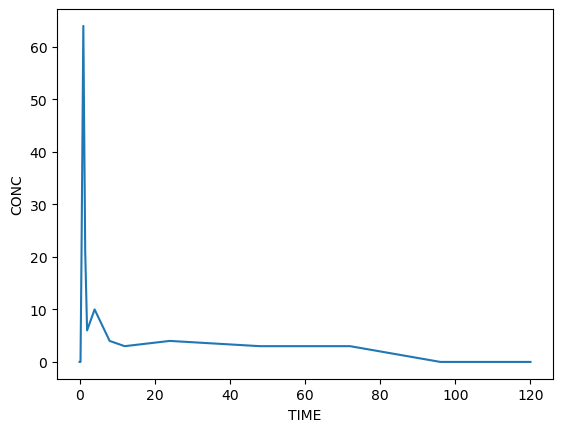

In [64]:
import seaborn as sns
from utils import safe_signed_log

plot_me = xth_df.loc[(xth_df['ID'] == 'M2') & (xth_df['TIME'] < 200), :].copy()
plot_me['conc_ln'] = safe_signed_log(plot_me['CONC'])
sns.lineplot(plot_me, x = 'TIME', y = 'CONC',)

In [43]:
0.693/0.037328

18.56515216459494

In [44]:
0.693/0.028881

23.99501402306014

In [ ]:
0.693/.045776

15.138937434463474

In [55]:
tmp

,ID,auc_per_time,start_time,end_time,slope,start_idx_slope_cv,intercept,r_value,adj_r2,n_points,max_conc,max_conc_time,abs_cv,cv_sign,start_time_mean_cv_sign,start_time_mean_abs_cv,start_time_std_mean_cv,auc_per_time_gt_lim,zero_window_time_start,consecutive_zero_windows
44,M2,3.368421,1.0,96.0,-0.024790,-1.411147,2.402221,-0.714999,0.450127,10,64,1.0,1.411147,-1.0,-1.0,0.950231,0.475465,1.0,96.0,1
45,M2,2.689076,1.0,120.0,-0.022124,-1.516033,2.360133,-0.767243,0.542958,11,64,1.0,1.516033,-1.0,-1.0,0.950231,0.475465,1.0,96.0,1
53,M2,3.161376,1.5,96.0,-0.019437,-2.088516,2.045194,-0.784762,0.560973,9,64,1.0,2.088516,-1.0,-1.0,1.630646,0.461643,1.0,96.0,1
54,M2,2.521097,1.5,120.0,-0.018056,-2.227623,2.020386,-0.840170,0.669122,10,64,1.0,2.227623,-1.0,-1.0,1.630646,0.461643,1.0,96.0,1
68,M2,3.000000,4.0,96.0,-0.015518,-1.112457,1.781095,-0.812080,0.591369,7,64,1.0,1.112457,-1.0,-1.0,0.820833,0.372824,1.0,96.0,1
69,M2,2.379310,4.0,120.0,-0.015085,-1.205181,1.770438,-0.874647,0.725842,8,64,1.0,1.205181,-1.0,-1.0,0.820833,0.372824,1.0,96.0,1
74,M2,2.818182,8.0,96.0,-0.011828,-1.629922,1.523957,-0.809934,0.569990,6,64,1.0,1.629922,-1.0,-1.0,1.501742,0.204218,1.0,96.0,1
75,M2,2.214286,8.0,120.0,-0.012439,-1.562868,1.542152,-0.889111,0.748622,7,64,1.0,1.562868,-1.0,-1.0,1.501742,0.204218,1.0,96.0,1
83,M2,2.666667,24.0,96.0,-0.017329,-0.393400,1.935601,-0.876650,0.652772,4,64,1.0,0.393400,-1.0,-1.0,0.357129,0.031918,1.0,96.0,1
84,M2,2.000000,24.0,120.0,-0.016130,-0.344653,1.878064,-0.920831,0.797239,5,64,1.0,0.344653,-1.0,-1.0,0.357129,0.031918,1.0,96.0,1


In [72]:
zero_zone_df

,ID,zero_window_time_start,consecutive_zero_windows
0,L1,24.0,4
1,L2,72.0,2
2,L3,24.0,4
3,L4,2.0,8
4,L5,24.0,4
5,L6,12.0,5
6,L7,12.0,5
7,L8,24.0,4
8,L9,48.0,3
9,L10,8.0,6


In [57]:
tmp = dfs[19].copy()

In [81]:
def estimate_k_halflife(dfs):
    res = []
    for tmp in dfs:
        #id = tmp['ID'].values[0]
        tmp = tmp.merge(zero_zone_df, how = 'left', on = 'ID')#.copy()
        f1 = tmp['start_time'] < tmp['zero_window_time_start']
        f2 = tmp['end_time'] <= tmp['zero_window_time_start']
        tmp = tmp.loc[f1 & f2, :]
        f = tmp['start_time_std_mean_cv'] == tmp['start_time_std_mean_cv'].min()
        out_df = tmp.loc[f, :].copy()
        out_df['window_k_est'] = -1*tmp.loc[f, 'slope'].values
        out_df['geom_mean_k_est'] = np.exp(np.mean(safe_signed_log(out_df['window_k_est'])))
        out_df['window_halflife_est'] = 0.693/out_df['window_k_est']
        out_df['geom_mean_halflife_est'] = np.exp(np.mean(safe_signed_log(out_df['window_halflife_est'])))
        res.append(out_df.copy())
    return pd.concat(res).reset_index(drop = True)

In [82]:
hl_df = estimate_k_halflife(dfs)

In [83]:
hl_df

,ID,auc_per_time,start_time,end_time,slope,start_idx_slope_cv,intercept,r_value,adj_r2,n_points,...,start_time_mean_abs_cv,start_time_std_mean_cv,auc_per_time_gt_lim,zero_window_time_start,consecutive_zero_windows,window_k_est,geom_mean_k_est,window_halflife_est,geom_mean_halflife_est,auc_per_time_lt_lim
0,L1,2.500000,12.0,24.0,-0.134120,NaN,3.218876,-1.000000,NaN,2,...,0.839639,0.227279,1.0,24.0,4,0.134120,0.134120,5.167021,5.167021,NaN
1,L2,2.000000,48.0,72.0,-0.057762,NaN,4.158883,-1.000000,NaN,2,...,0.411993,0.111242,1.0,72.0,2,0.057762,0.057762,11.997452,11.997452,NaN
2,L3,5.500000,4.0,8.0,-0.045580,NaN,1.974081,-1.000000,NaN,2,...,0.427774,0.141844,1.0,24.0,4,0.045580,0.071545,15.203907,9.686194,NaN
3,L3,4.750000,4.0,12.0,-0.086643,-0.310557,2.193084,-0.964544,0.860690,3,...,0.427774,0.141844,1.0,24.0,4,0.086643,0.071545,7.998301,9.686194,NaN
4,L3,2.800000,4.0,24.0,-0.092731,-0.279259,2.237729,-0.995010,0.985066,4,...,0.427774,0.141844,1.0,24.0,4,0.092731,0.071545,7.473199,9.686194,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,H16,21.500000,12.0,24.0,-0.019468,NaN,3.411669,-1.000000,NaN,2,...,0.332556,0.032869,1.0,72.0,2,0.019468,0.034650,35.597052,19.999881,0.0
128,H16,15.500000,12.0,48.0,-0.039868,-0.343809,3.754394,-0.984651,0.939075,3,...,0.332556,0.032869,1.0,72.0,2,0.039868,0.034650,17.382276,19.999881,0.0
129,H16,10.500000,12.0,72.0,-0.053601,-0.372501,4.068996,-0.982530,0.948047,4,...,0.332556,0.032869,1.0,72.0,2,0.053601,0.034650,12.928900,19.999881,0.0
130,H17,8.000000,12.0,24.0,-0.042569,NaN,2.813411,-1.000000,NaN,2,...,0.276822,0.078573,1.0,48.0,3,0.042569,0.052799,16.279528,13.125153,NaN


In [58]:
tmp = tmp.merge(zero_zone_df, how = 'left', on = 'ID')
f1 = tmp['start_time'] < tmp['zero_window_time_start']
f2 = tmp['end_time'] <= tmp['zero_window_time_start']
tmp = tmp.loc[f1 & f2, :]

In [65]:

f = tmp['start_time_std_mean_cv'] == tmp['start_time_std_mean_cv'].min()
subject_tmax = 0.693/(-1*tmp.loc[f, 'slope']).values
avg_tmax = np.exp(np.mean(np.log(subject_tmax)))
#try regresssing delta t vs cv at that delta t

In [66]:
avg_tmax

64.41994829824777

In [114]:
signs = look.groupby('start_time')['cv_sign'].mean()
start_idx_cv_mean = look.groupby('start_time')['abs_cv'].mean()
start_idx_cv_std = look.groupby('start_time')['abs_cv'].std()

In [119]:
start_idx_cv_std / start_idx_cv_mean

start_time
0.00     0.431303
0.25     0.432217
0.50     0.522009
1.00     0.410865
1.50     0.335802
2.00     0.132481
4.00     0.525206
8.00     0.218880
12.00    0.125904
24.00    0.141450
48.00    0.270009
72.00         NaN
96.00         NaN
Name: abs_cv, dtype: float64

<Axes: xlabel='TIME', ylabel='CONC_ln'>

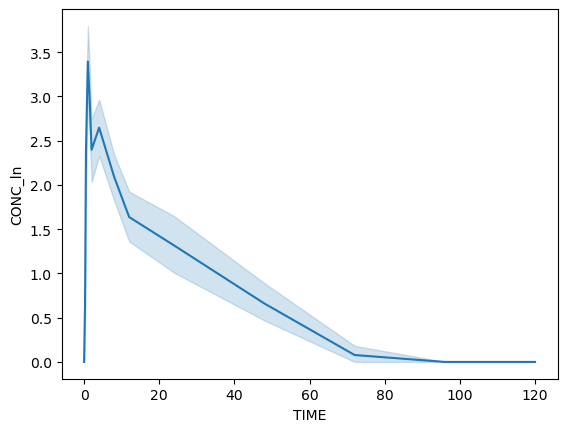

In [45]:
import seaborn as sns


sns.lineplot(xth_df, x = 'TIME', y = 'CONC_ln',)

In [25]:
from sklearn.metrics import auc

In [28]:
xth_df['ConcTime'] = xth_df['CONC'] * xth_df['TIME']

In [38]:
auc_df = (xth_df
 .groupby('ID')[['TIME', 'CONC']]
 .apply(lambda x: auc(x['TIME'], x['CONC']))
 .reset_index()
 .rename(columns = {0:'AUC'})
 )

auc_df.head()


,ID,AUC
0,H1,941.875
1,H10,820.875
2,H11,1038.500
3,H12,899.125
4,H13,425.000


In [39]:
#per subject, calculate AUC and AUMC
res = []
for sub in xth_df['ID'].unique():
    work_df = xth_df.loc[xth_df['ID'] == sub, :]
    auc_out = auc(work_df['TIME'].values, work_df['CONC'].values)
    auc_mc = auc(work_df['TIME'].values, work_df['ConcTime'].values)
    res.append({
        'ID':sub, 'AUC':auc_out, 'AUCMC':auc_mc
    })
res = pd.DataFrame(res)

In [42]:
#per subject calculate MRT
res['MRT'] = res['AUCMC']/res['AUC']
res

,ID,AUC,AUCMC,MRT
0,L1,72.000,523.2500,7.267361
1,L2,326.375,6615.4375,20.269437
2,L3,84.125,545.8125,6.488113
3,L4,12.500,13.5000,1.080000
4,L5,185.750,1064.6250,5.731494
5,L6,190.500,686.5000,3.603675
6,L7,143.375,471.1875,3.286399
7,L8,200.875,889.5625,4.428438
8,L9,134.625,1428.1875,10.608635
9,L10,25.875,58.6875,2.268116
